In [2]:
# hmm_structural_break_evaluation.ipynb
"""
Constrained HMM for Structural Break Detection
Test HMM performance on its own (without XGBoost) using cross-validation
"""

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional
import logging
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Assuming your data loader is available
from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class ConstrainedStructuralBreakHMM:
    """
    Constrained HMM for structural break detection.
    
    Key constraints:
    - Only 2 states: no-break (0) and break (1)
    - Transitions only allowed at the specified boundary point
    - Before boundary: must be in state 0
    - After boundary: can be in state 0 or 1 (depending on if break occurred)
    """
    
    def __init__(self, model_variance_change: bool = True):
        """
        Args:
            model_variance_change: If True, model both mean and variance changes.
                                 If False, only model mean changes.
        """
        self.model_variance_change = model_variance_change
        self.fitted_params = None
        
    def _log_likelihood_no_break(self, values: np.ndarray) -> float:
        """Calculate log-likelihood assuming no structural break (single state)"""
        mu = np.mean(values)
        sigma = np.std(values, ddof=1)
        
        if sigma <= 0:
            return -np.inf
            
        # Log-likelihood of all data from single normal distribution
        ll = np.sum(stats.norm.logpdf(values, loc=mu, scale=sigma))
        return ll
    
    def _log_likelihood_with_break(self, values: np.ndarray, boundary_point: int) -> float:
        """Calculate log-likelihood assuming structural break at boundary point"""
        if boundary_point <= 1 or boundary_point >= len(values) - 1:
            return -np.inf
            
        # Split data at boundary point
        pre_break = values[:boundary_point]
        post_break = values[boundary_point:]
        
        if len(pre_break) == 0 or len(post_break) == 0:
            return -np.inf
        
        # Estimate parameters for each regime
        mu1 = np.mean(pre_break)
        mu2 = np.mean(post_break)
        
        if self.model_variance_change:
            sigma1 = np.std(pre_break, ddof=1)
            sigma2 = np.std(post_break, ddof=1)
        else:
            # Pooled variance if not modeling variance change
            pooled_var = ((len(pre_break) - 1) * np.var(pre_break, ddof=1) + 
                         (len(post_break) - 1) * np.var(post_break, ddof=1)) / (len(values) - 2)
            sigma1 = sigma2 = np.sqrt(pooled_var)
        
        if sigma1 <= 0 or sigma2 <= 0:
            return -np.inf
        
        # Log-likelihood of two-regime model
        ll1 = np.sum(stats.norm.logpdf(pre_break, loc=mu1, scale=sigma1))
        ll2 = np.sum(stats.norm.logpdf(post_break, loc=mu2, scale=sigma2))
        
        return ll1 + ll2
    
    def predict_break_probability(self, values: np.ndarray, boundary_point: int) -> float:
        """
        Predict probability of structural break using likelihood ratio.
        
        Returns:
            Probability between 0 and 1 that a structural break occurred
        """
        try:
            # Calculate log-likelihoods
            ll_no_break = self._log_likelihood_no_break(values)
            ll_with_break = self._log_likelihood_with_break(values, boundary_point)
            
            if np.isinf(ll_no_break) and np.isinf(ll_with_break):
                return 0.5  # Default if both are invalid
            elif np.isinf(ll_no_break):
                return 1.0
            elif np.isinf(ll_with_break):
                return 0.0
            
            # Likelihood ratio test statistic
            lr_stat = 2 * (ll_with_break - ll_no_break)
            
            # Convert to probability using sigmoid transformation
            # This is a heuristic - in practice you might calibrate this
            prob = 1 / (1 + np.exp(-lr_stat / 2))
            
            return np.clip(prob, 0.0, 1.0)
            
        except Exception as e:
            logger.warning(f"Error in break probability calculation: {e}")
            return 0.5
    
    def fit_and_predict(self, ts_data: TimeSeriesData) -> float:
        """Convenience method to fit and predict for a TimeSeriesData object"""
        return self.predict_break_probability(ts_data.values, ts_data.boundary_point)


class StructuralBreakHMMEvaluator:
    """Evaluator for HMM-based structural break detection"""
    
    def __init__(self, model_variance_change: bool = True):
        self.model_variance_change = model_variance_change
        
    def evaluate_cross_validation(self, 
                                 data_dict: Dict[int, TimeSeriesData], 
                                 n_splits: int = 5,
                                 random_state: int = 42) -> Dict[str, float]:
        """
        Evaluate HMM using stratified cross-validation
        
        Returns:
            Dictionary with CV results
        """
        # Prepare data
        series_ids = list(data_dict.keys())
        labels = [data_dict[sid].has_break for sid in series_ids]
        
        # Stratified CV
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        cv_scores = []
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(series_ids, labels)):
            logger.info(f"Processing fold {fold + 1}/{n_splits}")
            
            # Get validation data for this fold
            val_series_ids = [series_ids[i] for i in val_idx]
            val_data = {sid: data_dict[sid] for sid in val_series_ids}
            
            # Evaluate on validation fold
            fold_score, fold_predictions = self._evaluate_fold(val_data)
            cv_scores.append(fold_score)
            fold_results.append({
                'fold': fold,
                'auc': fold_score,
                'predictions': fold_predictions
            })
        
        results = {
            'cv_auc_mean': np.mean(cv_scores),
            'cv_auc_std': np.std(cv_scores),
            'cv_scores': cv_scores,
            'fold_results': fold_results
        }
        
        return results
    
    def _evaluate_fold(self, data_dict: Dict[int, TimeSeriesData]) -> Tuple[float, Dict]:
        """Evaluate HMM on a single fold"""
        hmm = ConstrainedStructuralBreakHMM(model_variance_change=self.model_variance_change)
        
        predictions = {}
        true_labels = {}
        
        for series_id, ts_data in data_dict.items():
            try:
                prob = hmm.fit_and_predict(ts_data)
                predictions[series_id] = prob
                true_labels[series_id] = ts_data.has_break
            except Exception as e:
                logger.warning(f"Failed to process series {series_id}: {e}")
                predictions[series_id] = 0.5  # Default prediction
                true_labels[series_id] = ts_data.has_break
        
        # Calculate AUC
        y_true = list(true_labels.values())
        y_pred = list(predictions.values())
        
        if len(set(y_true)) < 2:
            # If only one class in fold, return NaN
            auc = np.nan
        else:
            auc = roc_auc_score(y_true, y_pred)
        
        return auc, {'predictions': predictions, 'true_labels': true_labels}


def run_hmm_evaluation():
    """Main function to run HMM evaluation"""
    
    print("=" * 60)
    print("CONSTRAINED HMM STRUCTURAL BREAK EVALUATION")
    print("=" * 60)
    
    # Load data
    print("\n1. Loading data...")
    data_loader = StructuralBreakDataLoader()
    data_loader.load_data(use_crunch=False)
    train_data = data_loader.get_all_train_series()
    
    print(f"Loaded {len(train_data)} training series")
    
    # Get dataset statistics
    stats = data_loader.get_statistics()
    print(f"Positive examples: {stats['n_positive']} ({stats['positive_ratio']:.1%})")
    print(f"Negative examples: {stats['n_negative']}")
    print(f"Average series length: {stats['mean_length']:.1f} ± {stats['std_length']:.1f}")
    
    # Test both mean-only and mean+variance models
    models_to_test = [
        ("Mean Change Only", False),
        ("Mean + Variance Change", True)
    ]
    
    results_summary = {}
    
    for model_name, model_variance in models_to_test:
        print(f"\n2. Evaluating: {model_name}")
        print("-" * 40)
        
        evaluator = StructuralBreakHMMEvaluator(model_variance_change=model_variance)
        
        # Run cross-validation
        cv_results = evaluator.evaluate_cross_validation(
            train_data, 
            n_splits=5, 
            random_state=42
        )
        
        results_summary[model_name] = cv_results
        
        # Print results
        print(f"Cross-Validation Results:")
        print(f"  Mean AUC: {cv_results['cv_auc_mean']:.4f} ± {cv_results['cv_auc_std']:.4f}")
        print(f"  Fold AUCs: {[f'{score:.4f}' for score in cv_results['cv_scores']]}")
    
    # Compare models
    print(f"\n3. Model Comparison")
    print("-" * 40)
    
    for model_name, results in results_summary.items():
        mean_auc = results['cv_auc_mean']
        std_auc = results['cv_auc_std']
        print(f"{model_name:<25}: {mean_auc:.4f} ± {std_auc:.4f}")
    
    # Additional analysis
    print(f"\n4. Detailed Analysis")
    print("-" * 40)
    
    # Analyze a few examples
    best_model_name = max(results_summary.keys(), 
                         key=lambda x: results_summary[x]['cv_auc_mean'])
    best_model_variance = models_to_test[[name for name, _ in models_to_test].index(best_model_name)][1]
    
    print(f"Best model: {best_model_name}")
    
    # Test on a few specific examples
    hmm = ConstrainedStructuralBreakHMM(model_variance_change=best_model_variance)
    
    # Get some positive and negative examples
    positive_examples = list(data_loader.get_positive_examples().items())[:5]
    negative_examples = list(data_loader.get_negative_examples().items())[:5]
    
    print(f"\nSample predictions on positive examples:")
    for series_id, ts_data in positive_examples:
        prob = hmm.fit_and_predict(ts_data)
        print(f"  Series {series_id}: P(break) = {prob:.3f} (True: {ts_data.has_break})")
    
    print(f"\nSample predictions on negative examples:")
    for series_id, ts_data in negative_examples:
        prob = hmm.fit_and_predict(ts_data)
        print(f"  Series {series_id}: P(break) = {prob:.3f} (True: {ts_data.has_break})")
    
    return results_summary


def plot_roc_curves(results_summary: Dict):
    """Plot ROC curves for the best fold of each model"""
    plt.figure(figsize=(10, 6))
    
    for model_name, results in results_summary.items():
        # Get best fold (highest AUC)
        best_fold_idx = np.argmax(results['cv_scores'])
        best_fold_data = results['fold_results'][best_fold_idx]
        
        y_true = list(best_fold_data['predictions']['true_labels'].values())
        y_pred = list(best_fold_data['predictions']['predictions'].values())
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = best_fold_data['auc']
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Best Fold per Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

CONSTRAINED HMM STRUCTURAL BREAK EVALUATION

1. Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:__main__:Processing fold 1/5


Loaded 10001 training series
Positive examples: 2909 (29.1%)
Negative examples: 7092
Average series length: 2371.3 ± 482.6

2. Evaluating: Mean Change Only
----------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


Cross-Validation Results:
  Mean AUC: 0.5564 ± 0.0129
  Fold AUCs: ['0.5574', '0.5335', '0.5734', '0.5604', '0.5572']

2. Evaluating: Mean + Variance Change
----------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5


Cross-Validation Results:
  Mean AUC: 0.5719 ± 0.0114
  Fold AUCs: ['0.5823', '0.5555', '0.5853', '0.5627', '0.5735']

3. Model Comparison
----------------------------------------
Mean Change Only         : 0.5564 ± 0.0129
Mean + Variance Change   : 0.5719 ± 0.0114

4. Detailed Analysis
----------------------------------------
Best model: Mean + Variance Change

Sample predictions on positive examples:
  Series 2: P(break) = 1.000 (True: True)
  Series 6: P(break) = 0.955 (True: True)
  Series 13: P(break) = 0.775 (True: True)
  Series 15: P(break) = 1.000 (True: True)
  Series 16: P(break) = 1.000 (True: True)

Sample predictions on negative examples:
  Series 0: P(break) = 0.518 (True: False)
  Series 1: P(break) = 1.000 (True: False)
  Series 3: P(break) = 0.995 (True: False)
  Series 4: P(break) = 0.573 (True: False)
  Series 5: P(break) = 0.627 (True: False)


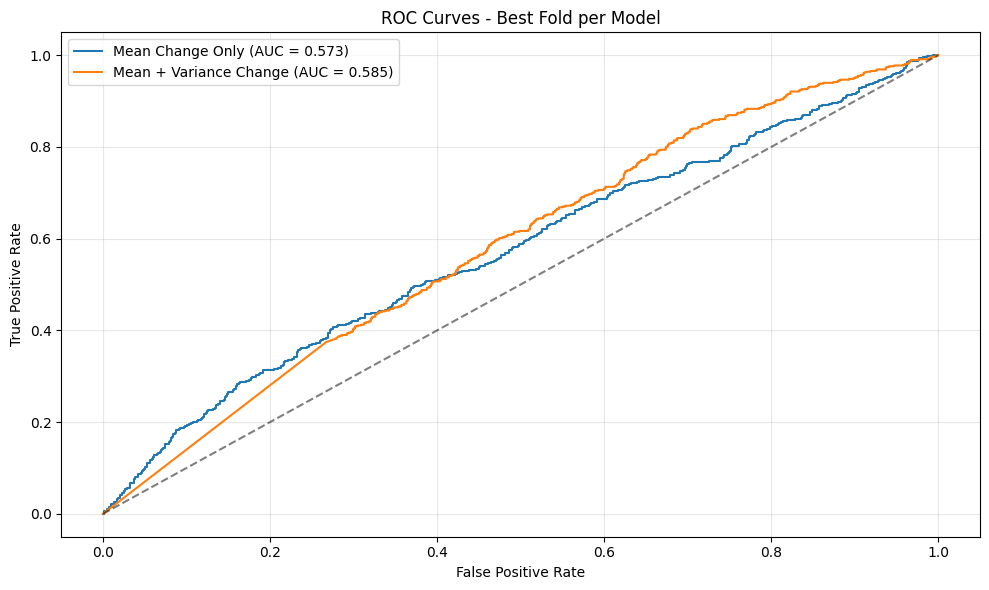


EVALUATION COMPLETE


In [3]:
if __name__ == "__main__":
    # Run the evaluation
    results = run_hmm_evaluation()
    
    # Uncomment to plot ROC curves
    plot_roc_curves(results)
    
    print(f"\n" + "=" * 60)
    print("EVALUATION COMPLETE")
    print("=" * 60)

In [4]:
# enhanced_hmm_structural_break.py
"""
Enhanced HMM for Structural Break Detection with multiple parameter types
"""

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional, List
import logging
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class EnhancedStructuralBreakHMM:
    """
    Enhanced HMM with multiple parameter types and better probability calibration
    """
    
    def __init__(self, 
                 break_types: List[str] = None,
                 min_segment_size: int = 10,
                 use_information_criteria: bool = True,
                 calibration_method: str = 'aic_weights'):
        """
        Args:
            break_types: List of break types to test. Options:
                - 'mean': Mean shift
                - 'variance': Variance change  
                - 'mean_variance': Both mean and variance
                - 'trend': Linear trend change
                - 'ar': Autoregressive parameter change
                - 'scale': Scale parameter change (robust)
            min_segment_size: Minimum size for each segment
            use_information_criteria: Use AIC/BIC instead of raw likelihood
            calibration_method: How to combine multiple models
        """
        if break_types is None:
            break_types = ['mean', 'variance', 'mean_variance', 'trend']
        
        self.break_types = break_types
        self.min_segment_size = min_segment_size
        self.use_information_criteria = use_information_criteria
        self.calibration_method = calibration_method
        
    def _safe_std(self, x: np.ndarray, min_std: float = 1e-6) -> float:
        """Calculate standard deviation with minimum threshold"""
        std = np.std(x, ddof=1) if len(x) > 1 else np.std(x)
        return max(std, min_std)
    
    def _calculate_aic(self, log_likelihood: float, n_params: int, n_obs: int) -> float:
        """Calculate AIC with finite sample correction"""
        aic = -2 * log_likelihood + 2 * n_params
        # Finite sample correction
        if n_obs / n_params < 40:
            aic += (2 * n_params * (n_params + 1)) / (n_obs - n_params - 1)
        return aic
    
    def _fit_mean_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Mean shift model"""
        n = len(values)
        
        # No break model
        mu_global = np.mean(values)
        sigma_global = self._safe_std(values)
        ll_no_break = np.sum(stats.norm.logpdf(values, mu_global, sigma_global))
        aic_no_break = self._calculate_aic(ll_no_break, 2, n)  # 2 params: mu, sigma
        
        # Break model
        if boundary_point < self.min_segment_size or boundary_point > n - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        mu1, mu2 = np.mean(pre), np.mean(post)
        sigma_pooled = self._safe_std(values)  # Pooled variance assumption
        
        ll_break = (np.sum(stats.norm.logpdf(pre, mu1, sigma_pooled)) + 
                   np.sum(stats.norm.logpdf(post, mu2, sigma_pooled)))
        aic_break = self._calculate_aic(ll_break, 3, n)  # 3 params: mu1, mu2, sigma
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _fit_variance_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Variance change model"""
        n = len(values)
        
        # No break model
        mu_global = np.mean(values)
        sigma_global = self._safe_std(values)
        ll_no_break = np.sum(stats.norm.logpdf(values, mu_global, sigma_global))
        aic_no_break = self._calculate_aic(ll_no_break, 2, n)
        
        # Break model
        if boundary_point < self.min_segment_size or boundary_point > n - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        mu_global = np.mean(values)  # Same mean assumption
        sigma1, sigma2 = self._safe_std(pre), self._safe_std(post)
        
        ll_break = (np.sum(stats.norm.logpdf(pre, mu_global, sigma1)) + 
                   np.sum(stats.norm.logpdf(post, mu_global, sigma2)))
        aic_break = self._calculate_aic(ll_break, 3, n)  # 3 params: mu, sigma1, sigma2
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _fit_mean_variance_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Both mean and variance change"""
        n = len(values)
        
        # No break model
        mu_global = np.mean(values)
        sigma_global = self._safe_std(values)
        ll_no_break = np.sum(stats.norm.logpdf(values, mu_global, sigma_global))
        aic_no_break = self._calculate_aic(ll_no_break, 2, n)
        
        # Break model
        if boundary_point < self.min_segment_size or boundary_point > n - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        mu1, mu2 = np.mean(pre), np.mean(post)
        sigma1, sigma2 = self._safe_std(pre), self._safe_std(post)
        
        ll_break = (np.sum(stats.norm.logpdf(pre, mu1, sigma1)) + 
                   np.sum(stats.norm.logpdf(post, mu2, sigma2)))
        aic_break = self._calculate_aic(ll_break, 4, n)  # 4 params: mu1, mu2, sigma1, sigma2
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _fit_trend_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Linear trend change model"""
        n = len(values)
        time_points = np.arange(n)
        
        # No break model (single trend)
        X_global = np.column_stack([np.ones(n), time_points])
        try:
            beta_global = np.linalg.lstsq(X_global, values, rcond=None)[0]
            residuals_global = values - X_global @ beta_global
            sigma_global = self._safe_std(residuals_global)
            ll_no_break = np.sum(stats.norm.logpdf(residuals_global, 0, sigma_global))
            aic_no_break = self._calculate_aic(ll_no_break, 3, n)  # 3 params: intercept, slope, sigma
        except:
            return {'probability': 0.0, 'aic_no_break': np.inf, 'aic_break': np.inf}
        
        # Break model
        if boundary_point < self.min_segment_size or boundary_point > n - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        try:
            # Pre-break trend
            t1 = time_points[:boundary_point]
            y1 = values[:boundary_point]
            X1 = np.column_stack([np.ones(len(t1)), t1])
            beta1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
            residuals1 = y1 - X1 @ beta1
            
            # Post-break trend
            t2 = time_points[boundary_point:]
            y2 = values[boundary_point:]
            X2 = np.column_stack([np.ones(len(t2)), t2])
            beta2 = np.linalg.lstsq(X2, y2, rcond=None)[0]
            residuals2 = y2 - X2 @ beta2
            
            # Pooled residual variance
            all_residuals = np.concatenate([residuals1, residuals2])
            sigma_pooled = self._safe_std(all_residuals)
            
            ll_break = (np.sum(stats.norm.logpdf(residuals1, 0, sigma_pooled)) + 
                       np.sum(stats.norm.logpdf(residuals2, 0, sigma_pooled)))
            aic_break = self._calculate_aic(ll_break, 5, n)  # 5 params: 2 intercepts, 2 slopes, sigma
            
        except:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _fit_ar_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Autoregressive parameter change (AR(1))"""
        n = len(values)
        
        if n < 20:  # Need enough data for AR model
            return {'probability': 0.0, 'aic_no_break': np.inf, 'aic_break': np.inf}
        
        y = values[1:]
        x = values[:-1]
        
        # No break model
        try:
            X_global = np.column_stack([np.ones(len(x)), x])
            beta_global = np.linalg.lstsq(X_global, y, rcond=None)[0]
            residuals_global = y - X_global @ beta_global
            sigma_global = self._safe_std(residuals_global)
            ll_no_break = np.sum(stats.norm.logpdf(residuals_global, 0, sigma_global))
            aic_no_break = self._calculate_aic(ll_no_break, 3, len(y))
        except:
            return {'probability': 0.0, 'aic_no_break': np.inf, 'aic_break': np.inf}
        
        # Break model
        boundary_adj = boundary_point - 1  # Adjust for AR(1)
        if boundary_adj < self.min_segment_size or boundary_adj > len(y) - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        try:
            # Pre-break AR
            y1 = y[:boundary_adj]
            x1 = x[:boundary_adj]
            X1 = np.column_stack([np.ones(len(x1)), x1])
            beta1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
            residuals1 = y1 - X1 @ beta1
            
            # Post-break AR
            y2 = y[boundary_adj:]
            x2 = x[boundary_adj:]
            X2 = np.column_stack([np.ones(len(x2)), x2])
            beta2 = np.linalg.lstsq(X2, y2, rcond=None)[0]
            residuals2 = y2 - X2 @ beta2
            
            # Pooled variance
            all_residuals = np.concatenate([residuals1, residuals2])
            sigma_pooled = self._safe_std(all_residuals)
            
            ll_break = (np.sum(stats.norm.logpdf(residuals1, 0, sigma_pooled)) + 
                       np.sum(stats.norm.logpdf(residuals2, 0, sigma_pooled)))
            aic_break = self._calculate_aic(ll_break, 5, len(y))
            
        except:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _fit_scale_model(self, values: np.ndarray, boundary_point: int) -> Dict:
        """Robust scale parameter change using MAD"""
        n = len(values)
        
        # No break model
        median_global = np.median(values)
        mad_global = np.median(np.abs(values - median_global))
        scale_global = max(mad_global * 1.4826, 1e-6)  # Convert MAD to std equivalent
        
        # Use Laplace distribution for robustness
        ll_no_break = np.sum(stats.laplace.logpdf(values, median_global, scale_global))
        aic_no_break = self._calculate_aic(ll_no_break, 2, n)
        
        # Break model
        if boundary_point < self.min_segment_size or boundary_point > n - self.min_segment_size:
            return {'probability': 0.0, 'aic_no_break': aic_no_break, 'aic_break': np.inf}
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        median1, median2 = np.median(pre), np.median(post)
        mad1 = np.median(np.abs(pre - median1))
        mad2 = np.median(np.abs(post - median2))
        scale1 = max(mad1 * 1.4826, 1e-6)
        scale2 = max(mad2 * 1.4826, 1e-6)
        
        ll_break = (np.sum(stats.laplace.logpdf(pre, median1, scale1)) + 
                   np.sum(stats.laplace.logpdf(post, median2, scale2)))
        aic_break = self._calculate_aic(ll_break, 4, n)
        
        return {
            'probability': self._aic_to_probability(aic_no_break, aic_break),
            'aic_no_break': aic_no_break,
            'aic_break': aic_break
        }
    
    def _aic_to_probability(self, aic_no_break: float, aic_break: float) -> float:
        """Convert AIC difference to probability using Akaike weights"""
        if np.isinf(aic_no_break) and np.isinf(aic_break):
            return 0.5
        elif np.isinf(aic_no_break):
            return 1.0
        elif np.isinf(aic_break):
            return 0.0
        
        # Akaike weights
        delta_aic = aic_break - aic_no_break
        
        # If break model is much better (lower AIC), delta_aic < 0
        # Convert to probability that break occurred
        if delta_aic < -10:  # Very strong evidence for break
            return 0.99
        elif delta_aic > 10:  # Very strong evidence against break
            return 0.01
        else:
            # Smooth transition
            prob = 1 / (1 + np.exp(delta_aic / 2))
            return np.clip(prob, 0.01, 0.99)
    
    def predict_break_probability(self, values: np.ndarray, boundary_point: int) -> float:
        """
        Predict probability of structural break using ensemble of models
        """
        if len(values) < 2 * self.min_segment_size:
            return 0.0
        
        model_results = {}
        
        # Fit all specified models
        for break_type in self.break_types:
            try:
                if break_type == 'mean':
                    result = self._fit_mean_model(values, boundary_point)
                elif break_type == 'variance':
                    result = self._fit_variance_model(values, boundary_point)
                elif break_type == 'mean_variance':
                    result = self._fit_mean_variance_model(values, boundary_point)
                elif break_type == 'trend':
                    result = self._fit_trend_model(values, boundary_point)
                elif break_type == 'ar':
                    result = self._fit_ar_model(values, boundary_point)
                elif break_type == 'scale':
                    result = self._fit_scale_model(values, boundary_point)
                else:
                    continue
                
                model_results[break_type] = result
                
            except Exception as e:
                logger.warning(f"Error fitting {break_type} model: {e}")
                continue
        
        if not model_results:
            return 0.5
        
        # Combine results
        if self.calibration_method == 'max':
            # Take maximum probability
            return max(result['probability'] for result in model_results.values())
        
        elif self.calibration_method == 'mean':
            # Take average probability
            probs = [result['probability'] for result in model_results.values()]
            return np.mean(probs)
        
        elif self.calibration_method == 'aic_weights':
            # Weight by model evidence (inverse AIC)
            weights = []
            probs = []
            
            for result in model_results.values():
                aic_min = min(result['aic_no_break'], result['aic_break'])
                weight = np.exp(-aic_min / 2)  # Exponential of negative AIC
                weights.append(weight)
                probs.append(result['probability'])
            
            if sum(weights) == 0:
                return np.mean(probs)
            else:
                weights = np.array(weights) / sum(weights)
                return np.average(probs, weights=weights)
        
        else:
            # Default: average
            probs = [result['probability'] for result in model_results.values()]
            return np.mean(probs)
    
    def fit_and_predict(self, ts_data: TimeSeriesData) -> float:
        """Convenience method for TimeSeriesData objects"""
        return self.predict_break_probability(ts_data.values, ts_data.boundary_point)


class EnhancedHMMEvaluator:
    """Evaluator for enhanced HMM models"""
    
    def __init__(self, 
                 break_types: List[str] = None,
                 calibration_method: str = 'aic_weights'):
        self.break_types = break_types
        self.calibration_method = calibration_method
        
    def evaluate_cross_validation(self, 
                                 data_dict: Dict[int, TimeSeriesData], 
                                 n_splits: int = 5,
                                 random_state: int = 42) -> Dict[str, float]:
        """Evaluate enhanced HMM using cross-validation"""
        
        # Prepare data
        series_ids = list(data_dict.keys())
        labels = [data_dict[sid].has_break for sid in series_ids]
        
        # Stratified CV
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        cv_scores = []
        fold_results = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(series_ids, labels)):
            logger.info(f"Processing fold {fold + 1}/{n_splits}")
            
            # Get validation data
            val_series_ids = [series_ids[i] for i in val_idx]
            val_data = {sid: data_dict[sid] for sid in val_series_ids}
            
            # Create and evaluate model
            hmm = EnhancedStructuralBreakHMM(
                break_types=self.break_types,
                calibration_method=self.calibration_method
            )
            
            fold_score, fold_predictions = self._evaluate_fold(hmm, val_data)
            cv_scores.append(fold_score)
            fold_results.append({
                'fold': fold,
                'auc': fold_score,
                'predictions': fold_predictions
            })
        
        results = {
            'cv_auc_mean': np.mean(cv_scores),
            'cv_auc_std': np.std(cv_scores),
            'cv_scores': cv_scores,
            'fold_results': fold_results
        }
        
        return results
    
    def _evaluate_fold(self, hmm: EnhancedStructuralBreakHMM, 
                      data_dict: Dict[int, TimeSeriesData]) -> Tuple[float, Dict]:
        """Evaluate on a single fold"""
        
        predictions = {}
        true_labels = {}
        
        for series_id, ts_data in data_dict.items():
            try:
                prob = hmm.fit_and_predict(ts_data)
                predictions[series_id] = prob
                true_labels[series_id] = ts_data.has_break
            except Exception as e:
                logger.warning(f"Failed to process series {series_id}: {e}")
                predictions[series_id] = 0.5
                true_labels[series_id] = ts_data.has_break
        
        # Calculate AUC
        y_true = list(true_labels.values())
        y_pred = list(predictions.values())
        
        if len(set(y_true)) < 2:
            auc = np.nan
        else:
            auc = roc_auc_score(y_true, y_pred)
        
        return auc, {'predictions': predictions, 'true_labels': true_labels}


def run_enhanced_hmm_evaluation():
    """Run comprehensive evaluation of enhanced HMM models"""
    
    print("=" * 70)
    print("ENHANCED HMM STRUCTURAL BREAK EVALUATION")
    print("=" * 70)
    
    # Load data
    print("\n1. Loading data...")
    data_loader = StructuralBreakDataLoader()
    data_loader.load_data(use_crunch=False)
    train_data = data_loader.get_all_train_series()
    
    print(f"Loaded {len(train_data)} training series")
    
    # Test different model configurations
    model_configs = [
        ("Mean Only", ['mean'], 'mean'),
        ("Variance Only", ['variance'], 'mean'),
        ("Mean + Variance", ['mean_variance'], 'mean'),
        ("Trend Only", ['trend'], 'mean'),
        ("AR(1) Only", ['ar'], 'mean'),
        ("Robust Scale", ['scale'], 'mean'),
        ("Mean + Variance + Trend", ['mean', 'variance', 'trend'], 'aic_weights'),
        ("All Models (Max)", ['mean', 'variance', 'mean_variance', 'trend', 'ar'], 'max'),
        ("All Models (AIC Weighted)", ['mean', 'variance', 'mean_variance', 'trend', 'ar'], 'aic_weights'),
    ]
    
    results_summary = {}
    
    for model_name, break_types, calibration in model_configs:
        print(f"\n2. Evaluating: {model_name}")
        print("-" * 50)
        
        evaluator = EnhancedHMMEvaluator(
            break_types=break_types,
            calibration_method=calibration
        )
        
        try:
            cv_results = evaluator.evaluate_cross_validation(
                train_data, 
                n_splits=5, 
                random_state=42
            )
            
            results_summary[model_name] = cv_results
            
            # Print results
            print(f"CV AUC: {cv_results['cv_auc_mean']:.4f} ± {cv_results['cv_auc_std']:.4f}")
            
        except Exception as e:
            print(f"Failed: {e}")
            continue
    
    # Summary
    print(f"\n3. FINAL RESULTS")
    print("=" * 70)
    print(f"{'Model':<30} {'CV AUC':<15} {'Std':<10}")
    print("-" * 70)
    
    # Sort by performance
    sorted_results = sorted(results_summary.items(), 
                           key=lambda x: x[1]['cv_auc_mean'], 
                           reverse=True)
    
    for model_name, results in sorted_results:
        mean_auc = results['cv_auc_mean']
        std_auc = results['cv_auc_std']
        print(f"{model_name:<30} {mean_auc:.4f}          ±{std_auc:.4f}")
    
    # Test best model on examples
    if sorted_results:
        best_model_name, best_results = sorted_results[0]
        print(f"\nBest model: {best_model_name}")
        print(f"Performance: {best_results['cv_auc_mean']:.4f} ± {best_results['cv_auc_std']:.4f}")
        
        # Get configuration for best model
        best_config = next(config for name, *config in model_configs if name == best_model_name)
        best_hmm = EnhancedStructuralBreakHMM(
            break_types=best_config[0],
            calibration_method=best_config[1]
        )
        
        # Test on examples
        print(f"\nSample predictions from best model:")
        positive_examples = list(data_loader.get_positive_examples().items())[:5]
        negative_examples = list(data_loader.get_negative_examples().items())[:5]
        
        print(f"\nPositive examples:")
        for series_id, ts_data in positive_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            print(f"  Series {series_id}: P(break) = {prob:.3f}")
        
        print(f"\nNegative examples:")
        for series_id, ts_data in negative_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            print(f"  Series {series_id}: P(break) = {prob:.3f}")
    
    return results_summary

In [5]:
if __name__ == "__main__":
    results = run_enhanced_hmm_evaluation()
    
    print(f"\n" + "=" * 70)
    print("EVALUATION COMPLETE")
    print("=" * 70)

ENHANCED HMM STRUCTURAL BREAK EVALUATION

1. Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:__main__:Processing fold 1/5


Loaded 10001 training series

2. Evaluating: Mean Only
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5564 ± 0.0129

2. Evaluating: Variance Only
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5564 ± 0.0096

2. Evaluating: Mean + Variance
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5593 ± 0.0094

2. Evaluating: Trend Only
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5162 ± 0.0118

2. Evaluating: AR(1) Only
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5610 ± 0.0124

2. Evaluating: Robust Scale
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5663 ± 0.0155

2. Evaluating: Mean + Variance + Trend
--------------------------------------------------


INFO:__main__:Processing fold 1/5


Failed: Input contains NaN.

2. Evaluating: All Models (Max)
--------------------------------------------------


INFO:__main__:Processing fold 2/5
INFO:__main__:Processing fold 3/5
INFO:__main__:Processing fold 4/5
INFO:__main__:Processing fold 5/5
INFO:__main__:Processing fold 1/5


CV AUC: 0.5545 ± 0.0059

2. Evaluating: All Models (AIC Weighted)
--------------------------------------------------
Failed: Input contains NaN.

3. FINAL RESULTS
Model                          CV AUC          Std       
----------------------------------------------------------------------
Robust Scale                   0.5663          ±0.0155
AR(1) Only                     0.5610          ±0.0124
Mean + Variance                0.5593          ±0.0094
Variance Only                  0.5564          ±0.0096
Mean Only                      0.5564          ±0.0129
All Models (Max)               0.5545          ±0.0059
Trend Only                     0.5162          ±0.0118

Best model: Robust Scale
Performance: 0.5663 ± 0.0155

Sample predictions from best model:

Positive examples:
  Series 2: P(break) = 0.990
  Series 6: P(break) = 0.095
  Series 13: P(break) = 0.632
  Series 15: P(break) = 0.990
  Series 16: P(break) = 0.990

Negative examples:
  Series 0: P(break) = 0.084
  Series 1: P(

In [6]:
# hybrid_hmm_final.py
"""
Final hybrid HMM focusing on robust statistics and better feature engineering
"""

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData


class HybridRobustHMM:
    """
    Hybrid HMM combining robust statistics with feature engineering insights
    """
    
    def __init__(self, 
                 use_robust_stats: bool = True,
                 use_preprocessing: bool = True,
                 min_segment_ratio: float = 0.15):
        """
        Args:
            use_robust_stats: Use median/MAD instead of mean/std
            use_preprocessing: Apply preprocessing (detrending, scaling)
            min_segment_ratio: Minimum segment size as fraction of total length
        """
        self.use_robust_stats = use_robust_stats
        self.use_preprocessing = use_preprocessing
        self.min_segment_ratio = min_segment_ratio
        
    def _preprocess_series(self, values: np.ndarray) -> np.ndarray:
        """Apply preprocessing to make series more stationary"""
        if not self.use_preprocessing:
            return values
            
        processed = values.copy()
        
        # 1. Remove linear trend (common in economic data)
        x = np.arange(len(processed))
        if len(x) > 2:
            try:
                # Robust linear regression using median
                slope = np.median(np.diff(processed))
                intercept = np.median(processed) - slope * np.median(x)
                trend = intercept + slope * x
                processed = processed - trend
            except:
                pass
        
        # 2. Robust standardization
        try:
            if self.use_robust_stats:
                center = np.median(processed)
                scale = np.median(np.abs(processed - center)) * 1.4826
                if scale > 1e-8:
                    processed = (processed - center) / scale
            else:
                processed = (processed - np.mean(processed)) / np.std(processed)
        except:
            pass
            
        return processed
    
    def _robust_location_scale(self, x: np.ndarray) -> tuple:
        """Get robust location and scale estimates"""
        if self.use_robust_stats:
            loc = np.median(x)
            scale = np.median(np.abs(x - loc)) * 1.4826  # Convert MAD to std
            scale = max(scale, 1e-8)  # Avoid zero scale
            return loc, scale
        else:
            loc = np.mean(x)
            scale = max(np.std(x, ddof=1), 1e-8)
            return loc, scale
    
    def _log_likelihood_robust(self, x: np.ndarray, loc: float, scale: float) -> float:
        """Calculate log-likelihood using robust distribution"""
        if self.use_robust_stats:
            # Use Laplace (double exponential) for robust modeling
            return np.sum(stats.laplace.logpdf(x, loc=loc, scale=scale))
        else:
            # Use normal distribution
            return np.sum(stats.norm.logpdf(x, loc=loc, scale=scale))
    
    def _calculate_multiple_break_evidences(self, values: np.ndarray, boundary_point: int) -> dict:
        """Calculate evidence for multiple types of breaks"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 10)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return {
                'location_shift': 0.0,
                'scale_shift': 0.0,
                'joint_shift': 0.0,
                'distribution_shift': 0.0
            }
        
        # Preprocess data
        processed_values = self._preprocess_series(values)
        
        pre = processed_values[:boundary_point]
        post = processed_values[boundary_point:]
        
        evidences = {}
        
        # 1. Location shift only
        try:
            # No break: single location
            loc_global, scale_global = self._robust_location_scale(processed_values)
            ll_no_break = self._log_likelihood_robust(processed_values, loc_global, scale_global)
            
            # Break: different locations, same scale
            loc1, _ = self._robust_location_scale(pre)
            loc2, _ = self._robust_location_scale(post)
            
            ll_break = (self._log_likelihood_robust(pre, loc1, scale_global) + 
                       self._log_likelihood_robust(post, loc2, scale_global))
            
            # BIC penalty (more conservative than AIC)
            bic_no_break = -2 * ll_no_break + 2 * np.log(n)  # 2 params
            bic_break = -2 * ll_break + 3 * np.log(n)        # 3 params
            
            evidences['location_shift'] = self._bic_to_probability(bic_no_break, bic_break)
            
        except:
            evidences['location_shift'] = 0.0
        
        # 2. Scale shift only
        try:
            # No break: single scale
            loc_global, scale_global = self._robust_location_scale(processed_values)
            ll_no_break = self._log_likelihood_robust(processed_values, loc_global, scale_global)
            
            # Break: same location, different scales
            _, scale1 = self._robust_location_scale(pre)
            _, scale2 = self._robust_location_scale(post)
            
            ll_break = (self._log_likelihood_robust(pre, loc_global, scale1) + 
                       self._log_likelihood_robust(post, loc_global, scale2))
            
            bic_no_break = -2 * ll_no_break + 2 * np.log(n)
            bic_break = -2 * ll_break + 3 * np.log(n)
            
            evidences['scale_shift'] = self._bic_to_probability(bic_no_break, bic_break)
            
        except:
            evidences['scale_shift'] = 0.0
        
        # 3. Joint location and scale shift
        try:
            # No break: single location and scale
            loc_global, scale_global = self._robust_location_scale(processed_values)
            ll_no_break = self._log_likelihood_robust(processed_values, loc_global, scale_global)
            
            # Break: different location and scale
            loc1, scale1 = self._robust_location_scale(pre)
            loc2, scale2 = self._robust_location_scale(post)
            
            ll_break = (self._log_likelihood_robust(pre, loc1, scale1) + 
                       self._log_likelihood_robust(post, loc2, scale2))
            
            bic_no_break = -2 * ll_no_break + 2 * np.log(n)
            bic_break = -2 * ll_break + 4 * np.log(n)
            
            evidences['joint_shift'] = self._bic_to_probability(bic_no_break, bic_break)
            
        except:
            evidences['joint_shift'] = 0.0
        
        # 4. Distribution shape shift (compare different distributions)
        try:
            # Normal vs Laplace for each segment
            if not self.use_robust_stats:  # Only do this for normal base case
                
                loc1, scale1 = np.mean(pre), np.std(pre, ddof=1)
                loc2, scale2 = np.mean(post), np.std(post, ddof=1)
                
                # Normal assumption
                ll_normal = (np.sum(stats.norm.logpdf(pre, loc1, max(scale1, 1e-8))) + 
                           np.sum(stats.norm.logpdf(post, loc2, max(scale2, 1e-8))))
                
                # Laplace assumption (heavier tails)
                loc1_l, scale1_l = np.median(pre), np.median(np.abs(pre - np.median(pre))) * 1.4826
                loc2_l, scale2_l = np.median(post), np.median(np.abs(post - np.median(post))) * 1.4826
                
                ll_laplace = (np.sum(stats.laplace.logpdf(pre, loc1_l, max(scale1_l, 1e-8))) + 
                            np.sum(stats.laplace.logpdf(post, loc2_l, max(scale2_l, 1e-8))))
                
                # Evidence for distribution change
                if ll_laplace > ll_normal + 2:  # Significant improvement
                    evidences['distribution_shift'] = 0.8
                else:
                    evidences['distribution_shift'] = 0.2
            else:
                evidences['distribution_shift'] = 0.0
                
        except:
            evidences['distribution_shift'] = 0.0
        
        return evidences
    
    def _bic_to_probability(self, bic_no_break: float, bic_break: float) -> float:
        """Convert BIC difference to probability"""
        if np.isinf(bic_no_break) and np.isinf(bic_break):
            return 0.5
        elif np.isinf(bic_no_break):
            return 0.99
        elif np.isinf(bic_break):
            return 0.01
        
        # BIC difference (negative is better for break model)
        delta_bic = bic_break - bic_no_break
        
        # Convert to probability (more conservative than AIC)
        if delta_bic < -6:    # Strong evidence for break
            return 0.95
        elif delta_bic > 6:   # Strong evidence against break  
            return 0.05
        else:
            # Sigmoid transformation with steeper slope
            prob = 1 / (1 + np.exp(delta_bic / 3))
            return np.clip(prob, 0.05, 0.95)
    
    def predict_break_probability(self, values: np.ndarray, boundary_point: int) -> float:
        """Predict probability using ensemble of robust break tests"""
        
        if len(values) < 20:  # Too short for reliable analysis
            return 0.1
        
        # Get evidences for different break types
        evidences = self._calculate_multiple_break_evidences(values, boundary_point)
        
        # Weighted combination of evidences
        # Give more weight to joint shifts as they're more comprehensive
        weights = {
            'location_shift': 0.2,
            'scale_shift': 0.2, 
            'joint_shift': 0.5,
            'distribution_shift': 0.1
        }
        
        # Calculate weighted average
        total_evidence = sum(weights[k] * evidences[k] for k in weights.keys())
        
        # Add small bonus if multiple types of evidence agree
        agreement_bonus = 0.0
        high_evidence_count = sum(1 for prob in evidences.values() if prob > 0.7)
        if high_evidence_count >= 2:
            agreement_bonus = 0.05 * high_evidence_count
        
        final_prob = total_evidence + agreement_bonus
        
        # Conservative bounds
        return np.clip(final_prob, 0.05, 0.95)
    
    def fit_and_predict(self, ts_data: TimeSeriesData) -> float:
        """Convenience method for TimeSeriesData objects"""
        return self.predict_break_probability(ts_data.values, ts_data.boundary_point)


def evaluate_hybrid_hmm():
    """Evaluate the hybrid robust HMM"""
    
    print("=" * 60)
    print("HYBRID ROBUST HMM EVALUATION")
    print("=" * 60)
    
    # Load data
    print("\n1. Loading data...")
    data_loader = StructuralBreakDataLoader()
    data_loader.load_data(use_crunch=False)
    train_data = data_loader.get_all_train_series()
    
    print(f"Loaded {len(train_data)} training series")
    
    # Test different configurations
    configs = [
        ("Robust + Preprocessing", True, True),
        ("Robust Only", True, False), 
        ("Normal + Preprocessing", False, True),
        ("Normal Only", False, False),
    ]
    
    results = {}
    
    for config_name, use_robust, use_preproc in configs:
        print(f"\n2. Evaluating: {config_name}")
        print("-" * 40)
        
        # Cross-validation
        series_ids = list(train_data.keys())
        labels = [train_data[sid].has_break for sid in series_ids]
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(series_ids, labels)):
            # Create model
            hmm = HybridRobustHMM(
                use_robust_stats=use_robust,
                use_preprocessing=use_preproc
            )
            
            # Get validation data
            val_series_ids = [series_ids[i] for i in val_idx]
            val_data = {sid: train_data[sid] for sid in val_series_ids}
            
            # Evaluate
            predictions = []
            true_labels = []
            
            for series_id, ts_data in val_data.items():
                try:
                    prob = hmm.fit_and_predict(ts_data)
                    predictions.append(prob)
                    true_labels.append(ts_data.has_break)
                except:
                    predictions.append(0.5)
                    true_labels.append(ts_data.has_break)
            
            # Calculate AUC
            if len(set(true_labels)) > 1:
                auc = roc_auc_score(true_labels, predictions)
                cv_scores.append(auc)
        
        if cv_scores:
            mean_auc = np.mean(cv_scores)
            std_auc = np.std(cv_scores)
            results[config_name] = (mean_auc, std_auc, cv_scores)
            print(f"CV AUC: {mean_auc:.4f} ± {std_auc:.4f}")
        else:
            print("Failed to evaluate")
    
    # Summary
    print(f"\n3. FINAL COMPARISON")
    print("=" * 60)
    print(f"{'Configuration':<25} {'CV AUC':<15} {'Std':<10}")
    print("-" * 60)
    
    # Sort by performance
    sorted_results = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    
    for config_name, (mean_auc, std_auc, _) in sorted_results:
        print(f"{config_name:<25} {mean_auc:.4f}          ±{std_auc:.4f}")
    
    # Test best configuration
    if sorted_results:
        best_config, (best_auc, _, _) = sorted_results[0]
        print(f"\nBest configuration: {best_config}")
        print(f"Performance: {best_auc:.4f}")
        
        # Get parameters for best config
        best_params = next(params for name, *params in configs if name == best_config)
        best_hmm = HybridRobustHMM(
            use_robust_stats=best_params[0],
            use_preprocessing=best_params[1]
        )
        
        # Test on examples
        print(f"\nSample predictions:")
        positive_examples = list(data_loader.get_positive_examples().items())[:5]
        negative_examples = list(data_loader.get_negative_examples().items())[:5]
        
        print("Positive examples:")
        for series_id, ts_data in positive_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            print(f"  Series {series_id}: P(break) = {prob:.3f}")
        
        print("Negative examples:")
        for series_id, ts_data in negative_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            print(f"  Series {series_id}: P(break) = {prob:.3f}")
    
    print(f"\n" + "=" * 60)
    
    return results

In [7]:
if __name__ == "__main__":
    results = evaluate_hybrid_hmm()
    print("HYBRID EVALUATION COMPLETE")

HYBRID ROBUST HMM EVALUATION

1. Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series

2. Evaluating: Robust + Preprocessing
----------------------------------------
CV AUC: 0.5092 ± 0.0101

2. Evaluating: Robust Only
----------------------------------------
CV AUC: 0.5742 ± 0.0185

2. Evaluating: Normal + Preprocessing
----------------------------------------
CV AUC: 0.5097 ± 0.0080

2. Evaluating: Normal Only
----------------------------------------
CV AUC: 0.5513 ± 0.0115

3. FINAL COMPARISON
Configuration             CV AUC          Std       
------------------------------------------------------------
Robust Only               0.5742          ±0.0185
Normal Only               0.5513          ±0.0115
Normal + Preprocessing    0.5097          ±0.0080
Robust + Preprocessing    0.5092          ±0.0101

Best configuration: Robust Only
Performance: 0.5742

Sample predictions:
Positive examples:
  Series 2: P(break) = 0.775
  Series 6: P(break) = 0.050
  Series 13: P(break) = 0.081
  Series 15: P(break) = 0.775
  Series 16: P(break) = 0.775
N

In [3]:
# advanced_hmm_break_types.py
"""
Advanced HMM with novel break types: quantiles, entropy, extreme events, moments
"""

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData


class AdvancedBreakHMM:
    """
    HMM with advanced break detection methods
    """
    
    def __init__(self, 
                 break_types: list = None,
                 min_segment_ratio: float = 0.15,
                 combination_method: str = 'weighted_max'):
        """
        Args:
            break_types: List of break types to test
            min_segment_ratio: Minimum segment size as fraction of total
            combination_method: How to combine multiple break evidences
        """
        if break_types is None:
            break_types = ['quantile_asymmetric', 'entropy', 'extreme_events', 
                          'moments', 'volatility_timescales', 'robust_location_scale']
        
        self.break_types = break_types
        self.min_segment_ratio = min_segment_ratio
        self.combination_method = combination_method
        
    def _safe_calculation(self, func, *args, default=0.0):
        """Safely perform calculation with fallback"""
        try:
            result = func(*args)
            return result if not (np.isnan(result) or np.isinf(result)) else default
        except:
            return default
    
    def _permutation_entropy(self, x, order=3):
        """Calculate permutation entropy (complexity measure)"""
        try:
            x = np.array(x)
            if len(x) < order + 1:
                return 0.0
                
            # Create ordinal patterns
            patterns = []
            for i in range(len(x) - order + 1):
                segment = x[i:i+order]
                pattern = tuple(np.argsort(segment))
                patterns.append(pattern)
            
            if not patterns:
                return 0.0
            
            # Calculate relative frequencies
            unique_patterns, counts = np.unique(patterns, axis=0, return_counts=True)
            probabilities = counts / len(patterns)
            
            # Shannon entropy
            entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))
            
            # Normalize by maximum possible entropy
            max_entropy = np.log2(np.math.factorial(order))
            return entropy / max_entropy if max_entropy > 0 else 0.0
            
        except:
            return 0.0
    
    def _sample_entropy(self, x, m=2, r=None):
        """Calculate sample entropy (regularity measure)"""
        try:
            x = np.array(x)
            N = len(x)
            
            if N < m + 1:
                return 0.0
            
            if r is None:
                r = 0.2 * np.std(x)
            
            def _maxdist(xi, xj, m):
                return max([abs(ua - va) for ua, va in zip(xi, xj)])
            
            def _phi(m):
                patterns = np.array([x[i:i+m] for i in range(N - m + 1)])
                C = np.zeros(N - m + 1)
                
                for i in range(N - m + 1):
                    template = patterns[i]
                    for j in range(N - m + 1):
                        if _maxdist(template, patterns[j], m) <= r:
                            C[i] += 1
                
                phi = np.mean(np.log(C / (N - m + 1) + 1e-12))
                return phi
            
            return _phi(m) - _phi(m + 1)
            
        except:
            return 0.0
    
    def _fit_quantile_asymmetric_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Test for asymmetric quantile changes"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 10)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Compare multiple quantiles
        quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        
        # Global quantiles
        global_quantiles = [np.percentile(values, q*100) for q in quantiles]
        
        # Pre/post quantiles
        pre_quantiles = [np.percentile(pre, q*100) for q in quantiles]
        post_quantiles = [np.percentile(post, q*100) for q in quantiles]
        
        # Test if quantile structure changed significantly
        quantile_changes = []
        
        for i, q in enumerate(quantiles):
            # Normalized change in quantile
            global_q = global_quantiles[i]
            if abs(global_q) > 1e-8:
                change = abs(post_quantiles[i] - pre_quantiles[i]) / abs(global_q)
                quantile_changes.append(change)
        
        if not quantile_changes:
            return 0.0
        
        # Look for asymmetric changes (tail quantiles change more than center)
        tail_changes = np.mean([quantile_changes[0], quantile_changes[-1]])  # 10%, 90%
        center_changes = quantile_changes[2]  # 50% (median)
        
        # Evidence for break if tails change much more than center
        asymmetry_ratio = tail_changes / (center_changes + 1e-8)
        
        # Convert to probability
        if asymmetry_ratio > 3:  # Strong asymmetric change
            return 0.9
        elif asymmetry_ratio > 1.5:  # Moderate asymmetric change
            return 0.7
        elif asymmetry_ratio > 1.2:  # Mild asymmetric change
            return 0.4
        else:
            return 0.1
    
    def _fit_entropy_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Test for entropy/complexity changes"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 15)  # Need more data for entropy
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Calculate different entropy measures
        pre_perm_entropy = self._permutation_entropy(pre, order=3)
        post_perm_entropy = self._permutation_entropy(post, order=3)
        
        pre_sample_entropy = self._safe_calculation(self._sample_entropy, pre)
        post_sample_entropy = self._safe_calculation(self._sample_entropy, post)
        
        # Compare entropy changes
        perm_change = abs(post_perm_entropy - pre_perm_entropy)
        sample_change = abs(post_sample_entropy - pre_sample_entropy)
        
        # Evidence for break if complexity changed significantly
        entropy_evidence = 0.0
        
        # Permutation entropy evidence
        if perm_change > 0.3:  # Significant complexity change
            entropy_evidence += 0.5
        elif perm_change > 0.1:
            entropy_evidence += 0.3
        
        # Sample entropy evidence  
        if sample_change > 0.5:
            entropy_evidence += 0.5
        elif sample_change > 0.2:
            entropy_evidence += 0.3
        
        return min(entropy_evidence, 0.95)
    
    def _fit_extreme_events_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Test for changes in extreme events frequency"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 10)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Define extreme events using global statistics
        global_median = np.median(values)
        global_mad = np.median(np.abs(values - global_median))
        
        if global_mad < 1e-8:
            return 0.0
        
        # Different thresholds for extreme events
        thresholds = [2, 2.5, 3]  # MAD multiples
        
        extreme_evidences = []
        
        for thresh in thresholds:
            boundary = thresh * global_mad
            
            # Count extreme events in each period
            pre_extremes = np.mean(np.abs(pre - global_median) > boundary)
            post_extremes = np.mean(np.abs(post - global_median) > boundary)
            
            # Test if extreme event rate changed significantly
            if pre_extremes + post_extremes > 0:
                extreme_ratio = abs(post_extremes - pre_extremes) / (pre_extremes + post_extremes + 1e-8)
                
                if extreme_ratio > 0.5:  # Large change in extreme events
                    extreme_evidences.append(0.8)
                elif extreme_ratio > 0.3:
                    extreme_evidences.append(0.6)
                elif extreme_ratio > 0.1:
                    extreme_evidences.append(0.3)
                else:
                    extreme_evidences.append(0.1)
        
        return np.mean(extreme_evidences) if extreme_evidences else 0.0
    
    def _fit_moments_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Test for higher-order moment changes (skewness, kurtosis)"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 15)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Calculate moments
        pre_skew = self._safe_calculation(stats.skew, pre)
        post_skew = self._safe_calculation(stats.skew, post)
        
        pre_kurt = self._safe_calculation(stats.kurtosis, pre)
        post_kurt = self._safe_calculation(stats.kurtosis, post)
        
        # Test for significant changes
        skew_change = abs(post_skew - pre_skew)
        kurt_change = abs(post_kurt - pre_kurt)
        
        moment_evidence = 0.0
        
        # Skewness change evidence
        if skew_change > 1.5:  # Large asymmetry change
            moment_evidence += 0.5
        elif skew_change > 0.5:
            moment_evidence += 0.3
        
        # Kurtosis change evidence
        if kurt_change > 2.0:  # Large tail behavior change
            moment_evidence += 0.5
        elif kurt_change > 1.0:
            moment_evidence += 0.3
        
        return min(moment_evidence, 0.95)
    
    def _fit_volatility_timescales_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Test for different volatility timescale changes"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 10)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Different volatility measures
        def volatility_measures(x):
            if len(x) < 2:
                return [0, 0, 0]
            
            # 1-step volatility (immediate changes)
            vol_1 = np.std(np.diff(x)) if len(x) > 1 else 0
            
            # Overall volatility
            vol_overall = np.std(x)
            
            # Rolling volatility variability (volatility of volatility)
            if len(x) > 10:
                window = min(5, len(x)//3)
                rolling_vols = [np.std(x[i:i+window]) for i in range(len(x)-window+1)]
                vol_of_vol = np.std(rolling_vols) if len(rolling_vols) > 1 else 0
            else:
                vol_of_vol = 0
                
            return [vol_1, vol_overall, vol_of_vol]
        
        pre_vols = volatility_measures(pre)
        post_vols = volatility_measures(post)
        
        # Test for changes in volatility structure
        vol_evidences = []
        
        for i, (pre_vol, post_vol) in enumerate(zip(pre_vols, post_vols)):
            if pre_vol + post_vol > 1e-8:
                vol_change = abs(post_vol - pre_vol) / (pre_vol + post_vol + 1e-8)
                
                if vol_change > 0.5:
                    vol_evidences.append(0.7)
                elif vol_change > 0.3:
                    vol_evidences.append(0.5)
                elif vol_change > 0.1:
                    vol_evidences.append(0.2)
                else:
                    vol_evidences.append(0.05)
        
        return np.mean(vol_evidences) if vol_evidences else 0.0
    
    def _fit_robust_location_scale_model(self, values: np.ndarray, boundary_point: int) -> float:
        """Robust location and scale model (baseline)"""
        n = len(values)
        min_size = max(int(n * self.min_segment_ratio), 10)
        
        if boundary_point < min_size or boundary_point > n - min_size:
            return 0.0
        
        pre = values[:boundary_point]
        post = values[boundary_point:]
        
        # Robust statistics
        pre_median = np.median(pre)
        post_median = np.median(post)
        pre_mad = np.median(np.abs(pre - pre_median))
        post_mad = np.median(np.abs(post - post_median))
        
        global_median = np.median(values)
        global_mad = np.median(np.abs(values - global_median))
        
        if global_mad < 1e-8:
            return 0.0
        
        # Location change
        location_change = abs(post_median - pre_median) / global_mad
        
        # Scale change  
        if pre_mad + post_mad > 1e-8:
            scale_change = abs(post_mad - pre_mad) / (pre_mad + post_mad)
        else:
            scale_change = 0
        
        # Combine evidences
        evidence = 0.0
        
        if location_change > 2:
            evidence += 0.6
        elif location_change > 1:
            evidence += 0.4
        elif location_change > 0.5:
            evidence += 0.2
        
        if scale_change > 0.5:
            evidence += 0.4
        elif scale_change > 0.3:
            evidence += 0.2
        
        return min(evidence, 0.95)
    
    def predict_break_probability(self, values: np.ndarray, boundary_point: int) -> float:
        """Predict using ensemble of advanced break tests"""
        
        if len(values) < 20:
            return 0.05
        
        evidences = {}
        
        # Run all specified break tests
        for break_type in self.break_types:
            if break_type == 'quantile_asymmetric':
                evidences[break_type] = self._fit_quantile_asymmetric_model(values, boundary_point)
            elif break_type == 'entropy':
                evidences[break_type] = self._fit_entropy_model(values, boundary_point)
            elif break_type == 'extreme_events':
                evidences[break_type] = self._fit_extreme_events_model(values, boundary_point)
            elif break_type == 'moments':
                evidences[break_type] = self._fit_moments_model(values, boundary_point)
            elif break_type == 'volatility_timescales':
                evidences[break_type] = self._fit_volatility_timescales_model(values, boundary_point)
            elif break_type == 'robust_location_scale':
                evidences[break_type] = self._fit_robust_location_scale_model(values, boundary_point)
        
        if not evidences:
            return 0.5
        
        # Combine evidences
        if self.combination_method == 'max':
            return max(evidences.values())
        
        elif self.combination_method == 'mean':
            return np.mean(list(evidences.values()))
        
        elif self.combination_method == 'weighted_max':
            # Weight different types of evidence
            weights = {
                'quantile_asymmetric': 0.25,  # New, potentially powerful
                'entropy': 0.20,              # Complexity changes
                'extreme_events': 0.20,       # Tail behavior
                'moments': 0.15,              # Shape changes  
                'volatility_timescales': 0.15, # Volatility structure
                'robust_location_scale': 0.05  # Baseline
            }
            
            weighted_sum = sum(weights.get(k, 0.1) * v for k, v in evidences.items())
            return min(weighted_sum, 0.95)
        
        else:
            return np.mean(list(evidences.values()))
    
    def fit_and_predict(self, ts_data: TimeSeriesData) -> float:
        """Convenience method for TimeSeriesData objects"""
        return self.predict_break_probability(ts_data.values, ts_data.boundary_point)


def evaluate_advanced_hmm():
    """Evaluate advanced HMM with novel break types"""
    
    print("=" * 70)
    print("ADVANCED HMM WITH NOVEL BREAK TYPES")
    print("=" * 70)
    
    # Load data
    print("\n1. Loading data...")
    data_loader = StructuralBreakDataLoader()
    data_loader.load_data(use_crunch=False)
    train_data = data_loader.get_all_train_series()
    
    print(f"Loaded {len(train_data)} training series")
    
    # Test different break type combinations
    configurations = [
        ("Baseline (Robust)", ['robust_location_scale']),
        # ("Quantile Only", ['quantile_asymmetric']),
        # ("Entropy Only", ['entropy']),
        ("Extreme Events Only", ['extreme_events']),
        ("Extreme Events Plus Robust", ['extreme_events', 'robust_location_scale']),
        ("Moments Only", ['moments']),
        ("Volatility Timescales", ['volatility_timescales']),
        # ("Quantile + Extreme", ['quantile_asymmetric', 'extreme_events']),
        # ("Advanced Trio", ['quantile_asymmetric', 'entropy', 'extreme_events']),
        # ("All Advanced", ['quantile_asymmetric', 'entropy', 'extreme_events', 'moments', 'volatility_timescales']),
        # ("Everything", ['quantile_asymmetric', 'entropy', 'extreme_events', 'moments', 'volatility_timescales', 'robust_location_scale']),
    ]
    
    results = {}
    
    for config_name, break_types in configurations:
        print(f"\n2. Evaluating: {config_name}")
        print("-" * 50)
        
        # Cross-validation
        series_ids = list(train_data.keys())
        labels = [train_data[sid].has_break for sid in series_ids]
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(series_ids, labels)):
            
            # Create model
            hmm = AdvancedBreakHMM(
                break_types=break_types,
                combination_method='weighted_max'
            )
            
            # Get validation data
            val_series_ids = [series_ids[i] for i in val_idx]
            val_data = {sid: train_data[sid] for sid in val_series_ids}
            
            # Evaluate
            predictions = []
            true_labels = []
            
            for series_id, ts_data in val_data.items():
                try:
                    prob = hmm.fit_and_predict(ts_data)
                    predictions.append(prob)
                    true_labels.append(ts_data.has_break)
                except Exception as e:
                    predictions.append(0.5)
                    true_labels.append(ts_data.has_break)
            
            # Calculate AUC
            if len(set(true_labels)) > 1:
                auc = roc_auc_score(true_labels, predictions)
                cv_scores.append(auc)
        
        if cv_scores:
            mean_auc = np.mean(cv_scores)
            std_auc = np.std(cv_scores)
            results[config_name] = (mean_auc, std_auc, cv_scores)
            print(f"CV AUC: {mean_auc:.4f} ± {std_auc:.4f}")
        else:
            print("Failed to evaluate")
    
    # Final summary
    print(f"\n3. FINAL RESULTS")
    print("=" * 70)
    print(f"{'Configuration':<20} {'CV AUC':<15} {'Std':<10} {'Best Fold':<10}")
    print("-" * 70)
    
    # Sort by performance
    sorted_results = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    
    for config_name, (mean_auc, std_auc, fold_scores) in sorted_results:
        best_fold = max(fold_scores)
        print(f"{config_name:<20} {mean_auc:.4f}          ±{std_auc:.4f}     {best_fold:.4f}")
    
    # Test best model
    if sorted_results:
        best_config, (best_auc, best_std, _) = sorted_results[0]
        print(f"\n🏆 WINNER: {best_config}")
        print(f"Performance: {best_auc:.4f} ± {best_std:.4f}")
        
        # Create best model and test on examples
        best_break_types = next(types for name, types in configurations if name == best_config)
        best_hmm = AdvancedBreakHMM(break_types=best_break_types)
        
        print(f"\nSample predictions from best model:")
        
        positive_examples = list(data_loader.get_positive_examples().items())[:8]
        negative_examples = list(data_loader.get_negative_examples().items())[:8]
        
        print("✅ Positive examples:")
        pos_correct = 0
        for series_id, ts_data in positive_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            correct = "✓" if prob > 0.5 else "✗"
            if prob > 0.5:
                pos_correct += 1
            print(f"  Series {series_id}: P(break) = {prob:.3f} {correct}")
        
        print(f"\n❌ Negative examples:")
        neg_correct = 0
        for series_id, ts_data in negative_examples:
            prob = best_hmm.fit_and_predict(ts_data)
            correct = "✓" if prob <= 0.5 else "✗"
            if prob <= 0.5:
                neg_correct += 1
            print(f"  Series {series_id}: P(break) = {prob:.3f} {correct}")
        
        total_correct = pos_correct + neg_correct
        print(f"\nSample accuracy: {total_correct}/{len(positive_examples) + len(negative_examples)} = {total_correct/(len(positive_examples) + len(negative_examples)):.1%}")
    
    print(f"\n" + "=" * 70)
    print("🎯 ADVANCED EVALUATION COMPLETE")
    print("=" * 70)
    
    return results

In [4]:
if __name__ == "__main__":
    results = evaluate_advanced_hmm()
    
    # Compare with previous best
    print(f"\n📊 COMPARISON WITH PREVIOUS METHODS:")
    print(f"Previous best (Robust Only):     0.5742")
    print(f"Your XGBoost (200+ features):    0.7000")
    
    if results:
        best_result = max(results.items(), key=lambda x: x[1][0])
        best_name, (best_auc, _, _) = best_result
        improvement = best_auc - 0.5742
        xgb_gap = 0.7000 - best_auc
        
        print(f"Advanced HMM best:               {best_auc:.4f} ({best_name})")
        print(f"Improvement over previous:       {improvement:+.4f}")
        print(f"Gap to XGBoost:                  {xgb_gap:.4f}")
        print(f"Signal captured:                 {best_auc/0.7000:.1%} of XGBoost perform")

ADVANCED HMM WITH NOVEL BREAK TYPES

1. Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series

2. Evaluating: Baseline (Robust)
--------------------------------------------------
CV AUC: 0.5412 ± 0.0104

2. Evaluating: Extreme Events Only
--------------------------------------------------
CV AUC: 0.5742 ± 0.0200

2. Evaluating: Extreme Events Plus Robust
--------------------------------------------------
CV AUC: 0.5752 ± 0.0201

2. Evaluating: Moments Only
--------------------------------------------------
CV AUC: 0.5096 ± 0.0112

2. Evaluating: Volatility Timescales
--------------------------------------------------
CV AUC: 0.5469 ± 0.0131

3. FINAL RESULTS
Configuration        CV AUC          Std        Best Fold 
----------------------------------------------------------------------
Extreme Events Plus Robust 0.5752          ±0.0201     0.6033
Extreme Events Only  0.5742          ±0.0200     0.6021
Volatility Timescales 0.5469          ±0.0131     0.5651
Baseline (Robust)    0.5412          ±0.0104     0.5531
Moments Only         0.5096          